# One-image four-masks DataBunch  

Kaggle's [Understanding Clouds from Satellite Images](https://www.kaggle.com/c/understanding_cloud_organization) competition is about marking out, on a satellite image, areas that have certain types of clouds.

Since each image can have up to four cloud types in it, we can try taking the image as the independent variable, while the dependent variable will consist of four masks, one for each cloud type.  Each mask will only contain values of either 0 or 1.  0 means the pixel does not belong to the cloud type; 1 means the pixel belongs to the cloud type.  

The dataloader will need to load mini-batches in which each item consists of an image (as the independent variable), plus four masks (as the dependent variable).

In [47]:
import sys
sys.path.append('/Users/jack/git_repos/fastai_dev/dev')
from local.data.all import *
from local.vision.all import *
from local.vision.core import *
from local.vision.augment import *

## Data

The four cloud types are:

In [2]:
CATS = ['fish', 'flower', 'gravel', 'sugar']

### Load the images' file paths and the annotations

In [49]:
SOURCE = Path('data')

In [50]:
items = get_image_files(SOURCE/'train_images')

In [51]:
IMG_SHAPE = PILImage.create(items[12]).shape

In [52]:
def load_train_annotation(fpath):
    df = pd.read_csv(fpath)
    df['Image'] = df.Image_Label.apply(lambda o: o.split('.')[0])
    df['Label'] = df.Image_Label.apply(lambda o: o.split('_')[1].lower())
    df.drop('Image_Label', axis=1, inplace=True)
    df = df[['Image', 'Label', 'EncodedPixels']]
    return df

In [53]:
annots = load_train_annotation(SOURCE/'train.csv')

### Decode Run-length Encoding

In [54]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    
    Copied from https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [55]:
class RLE_Decode(Transform):
    '''
    Image file path -> tensor
    '''
    def __init__(self, cat, annots, img_shape): 
        self.cat, self.annots, self.img_shape = cat,  annots, img_shape
        
    def encodes(self, o):
        df = self.annots[self.annots.Image == o.stem].fillna('')
        px_rle = df[df.Label == self.cat].EncodedPixels.values[0]
        return rle_decode(px_rle, IMG_SHAPE)

In [56]:
annots[annots.Image == items[16].stem]

,Image,Label,EncodedPixels
8600,61d6640,fish,NaN
8601,61d6640,flower,NaN
8602,61d6640,gravel,1349079 387 1350479 387 1351879 387 1353279 387 1354679 387 1356079 387 1357479 387 1358879 387 1360279 387 1361679 387 1363079 387 1364479 387 1365879 387 1367279 387 1368679 387 1370079 387 1371479 387 1372879 387 1374279 387 1375679 387 1377079 387 1378479 387 1379879 387 1381279 387 1382679 387 1384079 387 1385479 387 1386879 387 1388279 387 1389679 387 1391079 387 1392479 387 1393879 387 1395279 387 1396679 387 1398079 387 1399479 387 1400879 387 1402279 387 1403679 387 1405079 387 1406479 387 1407879 387 1409279 387 1410679 387 1412079 387 1413479 387 1414879 387 1416279 387 1417679 ...
8603,61d6640,sugar,373839 334 375239 334 376639 334 378039 334 379439 334 380839 334 382239 334 383639 334 385039 334 386439 334 387839 334 389239 334 390639 334 392039 334 393439 334 394839 334 396239 334 397639 334 399039 334 400439 334 401839 334 403239 334 404639 334 406039 334 407439 334 408839 334 410239 334 411639 334 413039 334 414439 334 415839 334 417239 334 418639 334 420039 334 421439 334 422839 334 424239 334 425639 334 427039 334 428439 334 429839 334 431239 334 432639 334 434039 334 435439 334 436839 334 438239 334 439639 334 441039 334 442439 334 443839 334 445239 334 446639 334 448039 334 44...


In [57]:
for cat in CATS: print(cat, RLE_Decode(cat, annots, IMG_SHAPE)(items[16]).sum())

fish 0
flower 0
gravel 326241
sugar 1264697


### Using 5 transform pipelines in `DataSource`'s `tfms`
The first pipeline is for the image, and the other four are for the four masks.

In [58]:
tfms = [[PILImage.create], 
        [RLE_Decode('fish', annots, IMG_SHAPE), PILMask.create],
        [RLE_Decode('flower', annots, IMG_SHAPE), PILMask.create],
        [RLE_Decode('gravel', annots, IMG_SHAPE), PILMask.create],
        [RLE_Decode('sugar', annots, IMG_SHAPE), PILMask.create]]

dsrc = DataSource(items, tfms=tfms)

In [59]:
dsrc[16]

(<local.vision.core.PILImage image mode=RGB size=2100x1400 at 0x1A32864AD0>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A32864E90>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A32864150>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A32864110>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1A32864810>)

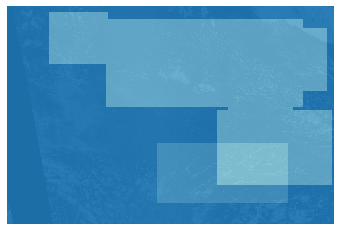

In [60]:
dsrc.show(dsrc[16])

#### Customized type to show an item differently

In [61]:
class ImageClouds(Tuple):
    def show(self, ctx=None, **kwargs):
        img, *masks = self
        if ctx is None: _, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
        img.show(axs[0])
        for ax, mask, cat in zip(axs[1:], masks, CATS):
            img.show(ax)
            mask.show(ax)
            ax.set_title(cat)
        for ax in axs: ax.axis('off')

In [62]:
imgcloud = ImageClouds(dsrc[16])

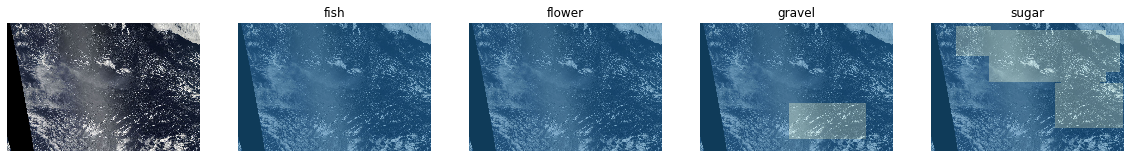

In [63]:
imgcloud.show()

### DataBunch

In [65]:
after_item_tfms = [ToTensor,]

In [66]:
after_batch_tfms = [Cuda(), IntToFloatTensor()]

In [67]:
dbch = dsrc.databunch(after_item=after_item_tfms, after_batch=after_batch_tfms, bs=4)

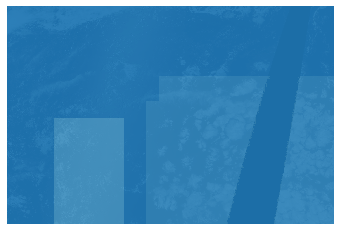

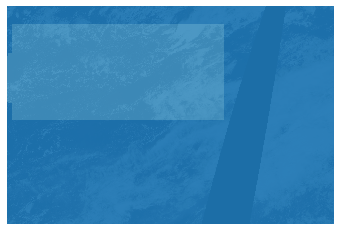

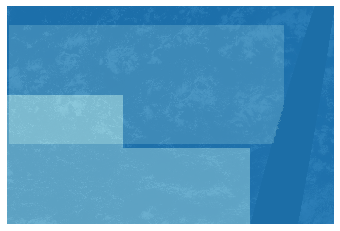

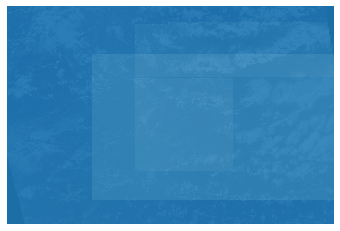

In [68]:
dbch.show_batch()

In [69]:
xb, *yb = dbch.one_batch()

4 images.

In [70]:
xb.shape

torch.Size([4, 3, 1400, 2100])

4 fish masks, 4 flower masks, 4 gravel masks, 4 sugar masks.

In [72]:
yb[0].shape, yb[1].shape, yb[2].shape, yb[3].shape

(torch.Size([4, 1400, 2100]),
 torch.Size([4, 1400, 2100]),
 torch.Size([4, 1400, 2100]),
 torch.Size([4, 1400, 2100]))

# - fin